# Case 03 - Task 03
Kia Vehicle Reviews Classification and Sentiment Analysis

In [1]:
# # Install the required packages
# !conda install -y pandas matplotlib seaborn -c conda-forge
# !pip install transformers
# !conda install pytorch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 pytorch-cuda=11.8 -c pytorch -c nvidia
# !conda  install numpy==1.26.4
# !conda install ipywidgets
# !conda install -c conda-forge datasets

In [2]:
# Step 1: Imports
import pandas as pd
from datasets import Dataset
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Load the Dataset
Begin by reading the `car_reviews.csv` file containing around 7000 customer reviews.

In [3]:
# Load CSV using pandas and convert to HuggingFace Dataset
df = pd.read_csv("car_reviews.csv")
print(df.columns)  # Confirm actual column name

df = df.rename(columns={"Review": "review"})

dataset = Dataset.from_pandas(df)

Index(['Review'], dtype='object')


## Step 2: Select a Zero-Shot Classification Model
Choose a zero-shot classification model from HuggingFace. The model `facebook/bart-large-mnli` is selected due to its strong performance in zero-shot classification tasks across a wide range of domains. It is trained on Multi-Genre Natural Language Inference (MNLI) which makes it suitable for our task.


In [4]:
# Zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

candidate_labels = [
    "talks about driving experience",
    "talks about features",
    "talks about value for money",
    "talks about issues",
    "other"
]

def classify_batch(batch):
    result = classifier(batch['review'], candidate_labels)
    return {"talks_about": [r["labels"][0] for r in result]}

# Apply batched classification
dataset = dataset.map(classify_batch, batched=True, batch_size=16)


Device set to use cuda:0


Map:   0%|          | 0/5959 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


## Step 4: Sentiment Analysis
For sentiment analysis, we use `distilbert-base-uncased-finetuned-sst-2-english`, a distilled version of BERT fine-tuned on SST-2. It is fast and accurate for classifying sentiment into positive and negative.

In [5]:
# Step 4: Sentiment analysis
from transformers import pipeline

# Load sentiment model with truncation enabled
sentiment_model = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment",
    truncation=True,
    max_length=512,
    device=0  # Use GPU
)

# Define function for batch sentiment prediction
def predict_sentiment(batch):
    result = sentiment_model(batch["review"], truncation=True, max_length=512)
    return {"sentiment": [r["label"] for r in result]}

# Apply the function on the dataset in batches
dataset = dataset.map(predict_sentiment, batched=True, batch_size=16)


c:\Users\kavin\.conda\envs\uniconnect\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Device set to use cuda:0


Map:   0%|          | 0/5959 [00:00<?, ? examples/s]

In [6]:
# Step 5: Convert back to DataFrame
df_final = dataset.to_pandas()
df_final.head()


,review,talks_about,sentiment
0,Bought 2017 Optima Hybrid in November 17. It w...,talks about value for money,LABEL_2
1,You get a lot for your money and great perfor...,talks about value for money,LABEL_2
2,This car is amazing and have no complaints. Y...,talks about value for money,LABEL_2
3,At 11k now in a lease for 39 months and it onl...,talks about issues,LABEL_0
4,"I've owned BMW, Lexus, Mercedes-Benz in the la...",talks about value for money,LABEL_2


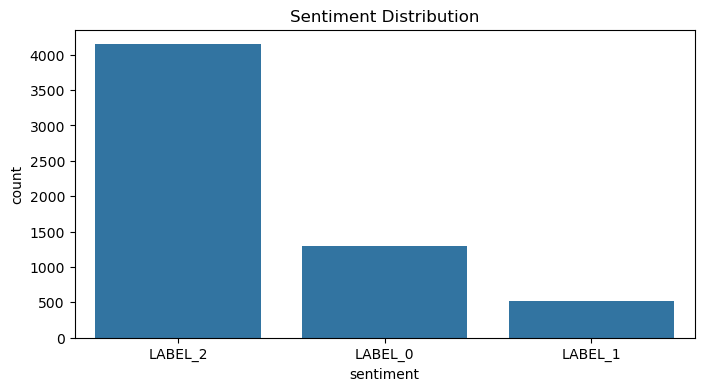

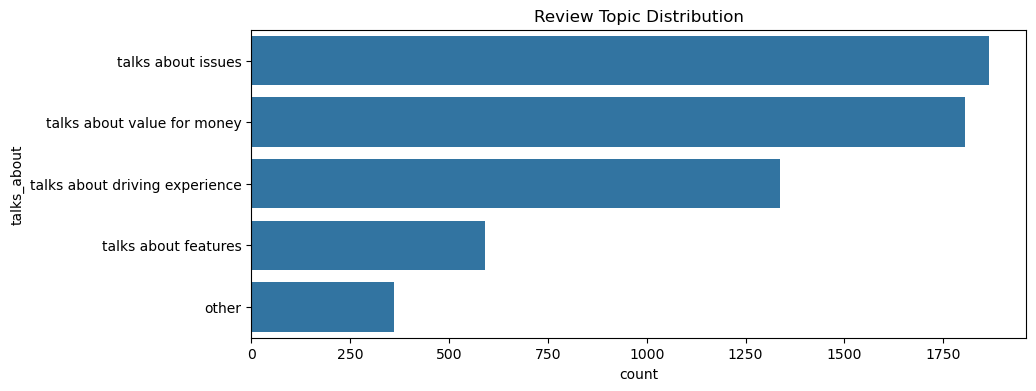

In [7]:
# Step 6: Visualize sentiment
plt.figure(figsize=(8, 4))
sns.countplot(x="sentiment", data=df_final)
plt.title("Sentiment Distribution")
plt.show()

# Step 7: Visualize topics
plt.figure(figsize=(10, 4))
sns.countplot(y="talks_about", data=df_final, order=df_final["talks_about"].value_counts().index)
plt.title("Review Topic Distribution")
plt.show()


In [8]:
# Step 8: Save results
df_final.to_csv("car_reviews_with_predictions.csv", index=False)
